# **PRÁCTICA 1 - Parte 2: Transfer learning**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos


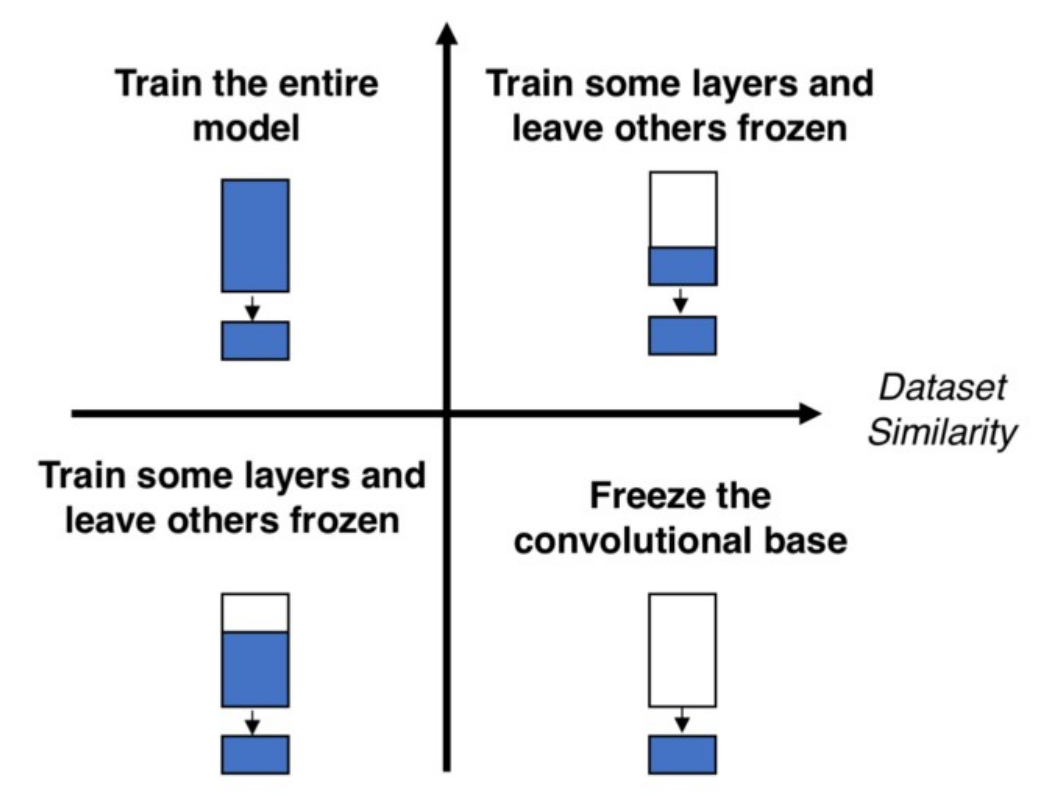

# **Prelaboratorio**

Lee la página:
https://keras.io/api/applications/

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.8.0


- Version del profesor 2.7.0. 
- Versión mia 2.8.0. 

# **LABORATORIO** 


## 1. Usar un modelo preentrenado directamente. 



### ResNet

https://datascience.eu/es/aprendizaje-automatico/una-vision-general-de-resnet-y-sus-variantes/

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# leer la imagen y preprocesar
img_path = 'imagen.png'
img = image.load_img(img_path, target_size=(224, 224))
#img = image.load_img(img_path)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
x.shape

(1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


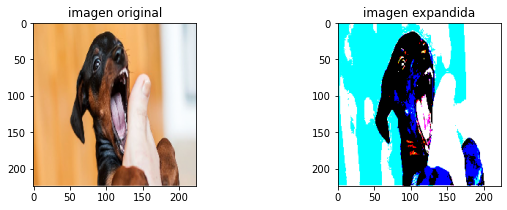

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (10,3))

plt.subplot(1,2,1)
plt.title('imagen original')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title("imagen expandida")
plt.imshow(x[0,:,:,:])

In [ ]:
# Predecir
preds = model.predict(x)

In [ ]:
# decodificar la predicción
print('Predicted:', decode_predictions(preds, top=10)[0])

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02089078', 'black-and-tan_coonhound', 0.43308473), ('n02090379', 'redbone', 0.20801643), ('n02088238', 'basset', 0.18852636), ('n02088466', 'bloodhound', 0.094175085), ('n02089867', 'Walker_hound', 0.039124735), ('n02088632', 'bluetick', 0.01888853), ('n02107142', 'Doberman', 0.0051302426), ('n02101006', 'Gordon_setter', 0.0042249514), ('n02808304', 'bath_towel', 0.0037964866), ('n02087394', 'Rhodesian_ridgeback', 0.0015493223)]


## 2. Transfer learning: extracción de características.


### Extraer características VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Leemos VGG16 pero sin la última capa!!
model = VGG16(weights='imagenet', include_top=False)

img_path = 'imagen.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
x.shape

(1, 224, 224, 3)

In [ ]:
features.shape

(1, 7, 7, 512)

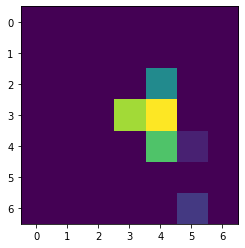

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(features[0,:,:,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


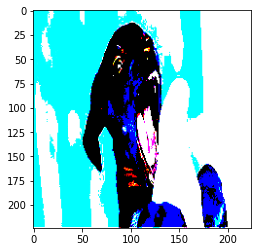

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x[0,:,:,:])

### Extraer características de una capa cualquiera VGG19


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet')

574726144/574710816 [==============================] - 10s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)

img_path = 'imagen.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

block4_pool_features = model.predict(x)

In [ ]:
block4_pool_features.shape

(1, 14, 14, 512)

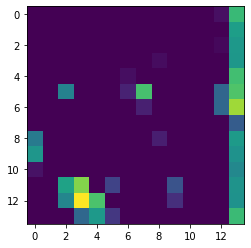

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(block4_pool_features[0,:,:,0])

## 3. Transfer learning: re-entrenar un modelo entero para otros datos


### Fine-tune InceptionV3 en otra base de datos. CIFAR10

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input


input_tensor = Input(shape=(128, 128, 3))  # tamaño imagenes de entrada 128 minimo

# create the base pre-trained model
base_model = InceptionV3(input_tensor=input_tensor,weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


### Reentrenar todo

In [ ]:
# Cogemos la salida y añadimos 3 capas 
x = base_model.output
# Pooling
x = GlobalAveragePooling2D()(x)
# Fully-connected
#x = Dense(1024, activation='relu')(x)
# Regresión logística con 10 salidas
predictions = Dense(10, activation='softmax')(x)

# Modelo nuevo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilamos
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
from tensorflow.keras.datasets import cifar10

#download cifar10 data and split into train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()


X_train = X_train[0:1000,:,:,:]
X_test = X_test[0:100,:,:,:]
y_train = y_train[0:1000,]
y_test = y_test[0:100,]

from tensorflow.keras.utils import to_categorical

#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
X_train.dtype

dtype('uint8')

In [ ]:
import tensorflow as tf
X_train.dtype
X_train2 = tf.image.resize(X_train, [128,128])
X_test2 = tf.image.resize(X_test, [128,128])


In [ ]:
score = model.evaluate(X_test2,y_test,steps=300)

300/300 [==============================] - 7s 16ms/step - loss: 98.0826 - accuracy: 0.0600


In [ ]:
print(score)

[98.08258056640625, 0.05999999865889549]


In [ ]:
score_tr = model.evaluate(X_train2,y_train,steps=300)

300/300 [==============================] - 37s 118ms/step - loss: 102.7072 - accuracy: 0.0840


In [ ]:
print(score_tr)

[102.70724487304688, 0.08399999886751175]


## 4. Transfer learning: Entrenar solo las últimas capas

In [ ]:
# Definimos como no entrenables las capas que hay en el modelo original
for layer in base_model.layers:
    layer.trainable = False

# Compilamos
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:

# Entrenamos
model.fit(X_train2,y_train,steps_per_epoch=300,epochs = 10)

Epoch 1/10
300/300 [==============================] - 15s 32ms/step - loss: 71.1100 - accuracy: 0.1733
Epoch 2/10
300/300 [==============================] - 10s 32ms/step - loss: 61.5470 - accuracy: 0.2008
Epoch 3/10
300/300 [==============================] - 10s 32ms/step - loss: 54.4722 - accuracy: 0.2517
Epoch 4/10
300/300 [==============================] - 10s 32ms/step - loss: 51.6835 - accuracy: 0.2825
Epoch 5/10
300/300 [==============================] - 10s 32ms/step - loss: 50.8044 - accuracy: 0.2642
Epoch 6/10
300/300 [==============================] - 10s 32ms/step - loss: 44.9908 - accuracy: 0.3275
Epoch 7/10
300/300 [==============================] - 10s 32ms/step - loss: 44.8193 - accuracy: 0.3400
Epoch 8/10
300/300 [==============================] - 10s 32ms/step - loss: 42.5394 - accuracy: 0.3508
Epoch 9/10
300/300 [==============================] - 3s 11ms/step - loss: 39.9723 - accuracy: 0.3825


In [ ]:
score2 = model.evaluate(X_test2,y_test,steps=300)

300/300 [==============================] - 3s 9ms/step - loss: 61.1625 - accuracy: 0.2100


In [ ]:
print(score2)

[93.86500088862803, 0.08]


In [ ]:
score2_tr = model.evaluate(X_train2,y_train,steps=300)

1000/1000 [==============================] - 6s 6ms/sample - loss: 92.7621 - accuracy: 0.0910


In [ ]:
print(score2_tr)

[92.91290616989136, 0.091]


### Entrenar las últimas n capas

In [ ]:
n = 249

# Definimos como entrenables las últimas n capas
for layer in model.layers[:n]:
   layer.trainable = False
for layer in model.layers[n:]:
   layer.trainable = True

# Recompilamos
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:


# Reentrenamos
model.fit(X_train2,y_train,steps_per_epoch=300)


Train on 1000 samples
1000/1000 [==============================] - 9s 9ms/sample - loss: 1.9498 - accuracy: 0.2980


In [ ]:
score3 = model.evaluate(X_test2,y_test,steps=300)

100/100 [==============================] - 3s 28ms/sample - loss: 115.2870 - accuracy: 0.1100


In [ ]:
print(score3)

[115.06531867172569, 0.11]


In [ ]:
score3_tr = model.evaluate(X_train2,y_train,steps=300)

1000/1000 [==============================] - 5s 5ms/sample - loss: 119.8688 - accuracy: 0.1120


In [ ]:
print(score3_tr)

[120.0558402633667, 0.112]


## 5. Mas sitios con modelos:




- Tensorflow hub

https://tfhub.dev/


- Tensorflow js

https://www.tensorflow.org/js/models


- Tensorflow detection model zoo

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md


- Tensorflow models

https://github.com/tensorflow/models/

Por ejemplo:

https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2


# **Ejercicios**

1) Define un nuevo modelo utilizando un modelo preentrando como base y utilízalo para CIFAR100. Guarda la estructura, las curvas de entrenamiento, loss entrenamiento, loss de validación, loss de test, accuracy entrenamiento, accuracy de validación, accuracy de test, número de parámetros.

2) Prueba un modelo de https://tfhub.dev/ con una imagen de internet